# POLI 175 - Lecture 09

## Regression Analysis

## Announcement

1. I am going through a mailbox disaster right now. About 300 unanswered emails. Will catch up with your emails by next week.

2. We are one class behind the schedule. It is all good, since I can compress the `beyond linearity` lecture.

3. The trade-off here is to cover more content x cover more in-depth. I will try to strive a good balance between those.

## Recap

So far, we learned:

- What is Machine Learning, and the main trade-offs involved in it.

- How to use `numpy`, `pandas`, `matplotlib`, and `seaborn`.

- Linear regression theory, bivariate regression in practice, and diagnostics.

**Great work!**

- Do you have any questions about any of these contents?

## Plan for today

**Regression**:

- Multivariate Regression in Python:

- Diagnostics of regression estimates

- Best practices

(and hopefully!)

**Classification**:

- Starting Classification

## Data

Today we are going to use the `prestige` dataset.

| **Variable** | **Meaning**                                                                                                                                                        |
|--------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `type`         | Type of occupation. A factor with the following levels: <br>`prof`, professional and managerial; `wc`, white-collar; `bc`, blue-collar.           |
| `income`      | Percentage of occupational incumbents in the 1950 US Census who earned USD 3,500 <br>or more per year (about USD 36,000 in 2017 US dollars).                             |
| `education`    | Percentage of occupational incumbents in 1950 who were high school graduates<br>(which, were we cynical, we would say it is roughly equivalent to a Ph.D. in 2017) |
| `prestige`     | Percentage of respondents in a social survey who rated the occupation as “good” <br>or better in prestige                                                          |
| `profession`   | Name of the profession                                                                                                                                             |


Plus some other `cooked` data.

In [7]:
## Loading the data
import pandas as pd
import numpy as np
duncan = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/Duncan.csv')
duncan = duncan.set_index('profession')

## Loading Libraries and Modules
# Running the regression:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt

# Getting up to speed
model = ols('prestige ~ income', data = duncan).fit()
summary_info = model.get_influence().summary_frame()
summary_info['fittedvalues'] = model.fittedvalues

## Diagnostics (continued)

### High Leverage

- Have very unusual $x_i$ values that could potentially tilt the regression line towards them.

- **If high leverage and outlier, bad combination!**

![reg](../img/fig9.png)

- Plot: Leverage x Studentizided residuals

- The best: You should find no extreme values in the plot.

- The ugly: An extreme value can affect your fit.

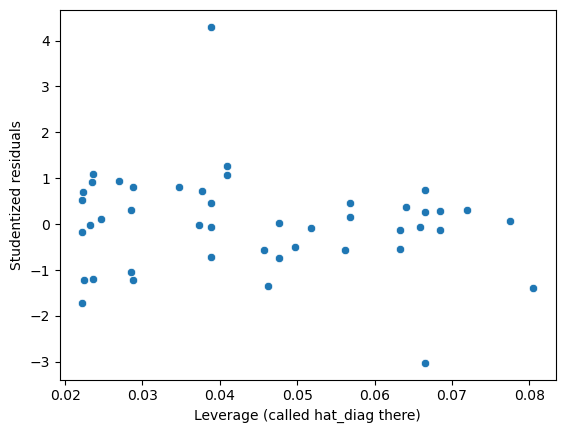

In [3]:
## Checking the Leverage
sns.scatterplot(x = 'hat_diag', y = 'student_resid', data = summary_info)
plt.xlabel("Leverage (called hat_diag there)")
plt.ylabel("Studentized residuals")
plt.show()

In [4]:
summary_info.sort_values('hat_diag', ascending = False).head()

,dfb_Intercept,dfb_income,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits,fittedvalues
profession,,,,,,,,,
RR.engineer,0.195291,-0.350303,0.082942,-1.376371,0.080515,-0.407288,-1.391264,-0.411695,89.968138
dentist,-0.008852,0.016111,0.000186,0.066546,0.077574,0.019298,0.065771,0.019073,88.887749
banker,-0.038302,0.072014,0.003833,0.314521,0.071920,0.087555,0.311200,0.086631,86.726969
coal.miner,0.079282,-0.065387,0.003233,0.296538,0.068497,0.080412,0.293370,0.079553,10.019302
janitor,-0.032115,0.026487,0.000531,-0.120224,0.068497,-0.032601,-0.118838,-0.032225,10.019302


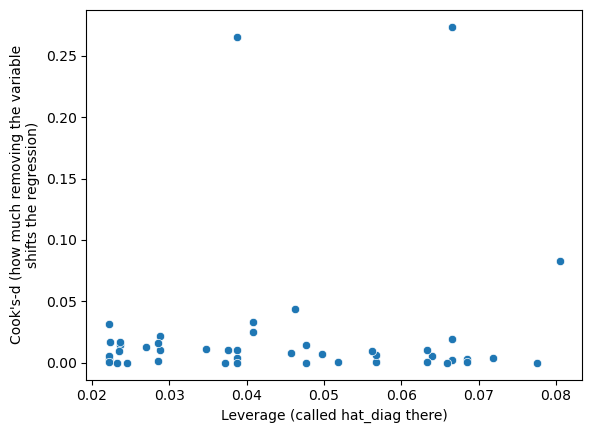

In [5]:
## Checking the Leverage and Outliers: Cook's-d x Leverage
sns.scatterplot(x = 'hat_diag', y = 'cooks_d', data = summary_info)
plt.xlabel("Leverage (called hat_diag there)")
plt.ylabel("Cook's-d (how much removing the variable\nshifts the regression)")
plt.show()

In [21]:
# Checking the Cook's-d measure
summary_info.sort_values('cooks_d', ascending = False).head()

,dfb_Intercept,dfb_income,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits,fittedvalues,abs_student_resid
profession,,,,,,,,,,
conductor,0.337190,-0.658212,0.273524,-2.769568,0.066571,-0.739626,-3.019729,-0.806433,84.566190,3.019729
minister,0.815826,-0.564624,0.265244,3.625357,0.038796,0.728346,4.299856,0.863855,25.144758,4.299856
RR.engineer,0.195291,-0.350303,0.082942,-1.376371,0.080515,-0.407288,-1.391264,-0.411695,89.968138,1.391264
reporter,0.083088,-0.215488,0.043817,-1.344051,0.046267,-0.296031,-1.357144,-0.298915,74.842683,1.357144
professor,-0.056487,0.176277,0.033585,1.255527,0.040869,0.259171,1.264232,0.260968,71.601514,1.264232


## Multiple Linear Regression

- So far:
    + Is there a relationship between `prestige` and `income`? **Yes**
    + How strong is the relationship between `prestige` and `income`? **Yes**
    + Which variables are associated with `prestige`?
    + How can we accurately predict the prestige of professions not studied in this survey? **Yes, so far...**
    + Is the relationship linear? **Yes, so far...**
    + Is there a synergy among predictors?
    
- Can we do better? **Yes**, we have other predictors that we didn't not explore.

## Multiple Linear Regression

Let's fit the following model:

$$ \text{prestige} = \beta_0 + \beta_1\text{income} + \beta_2\text{education} + \varepsilon $$

In [22]:
## Running the actual regression:

# Create the model.Fit the model
model3 = ols('prestige ~ income + education', data = duncan).fit()

# Print the parameters
print(model3.params)

Intercept   -6.064663
income       0.598733
education    0.545834
dtype: float64


Meaning:

$$ \text{prestige} \ \approx \ -6.06 + 0.60\text{income} + 0.55\text{education} $$

## F-Statistic

Are we doing better than the linear regression? We can test that!

**Null hypothesis:** The model with fewer parameters is better.

**Alternative hypothesis:** At least one variable in the new model does well.

In [23]:
## Anova for model without x model with education
anova_lm(model, model3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,43.0,13022.800135,0.0,NaN,NaN,NaN
1,42.0,7506.698653,1.0,5516.101482,30.862603,0.000002


## RSE and R$^2$

We can also look at the Residual Standard Error and the R$^2$ to determine this:

In [24]:
# Model with only income
mse = model.mse_resid
print('The mean squared error: ' + str(mse))

# Residual Standard Error
rse = np.sqrt(mse)
print('The Residual Standard Error: ' + str(rse))

# R-squared
rsq = model.rsquared
print(rsq)

The mean squared error: 302.855817097006
The Residual Standard Error: 17.402753147045615
0.701911139847978


## RSE and R$^2$

We can also look at the Residual Standard Error and the R$^2$ to determine this:

In [25]:
# Model with income and education
mse = model3.mse_resid
print('The mean squared error: ' + str(mse))

# Residual Standard Error
rse = np.sqrt(mse)
print('The Residual Standard Error: ' + str(rse))

# R-squared
rsq = model3.rsquared
print(rsq)

The mean squared error: 178.7309203117738
The Residual Standard Error: 13.3690283981961
0.8281734172543814


## Diagnostics

Besides the diagnostics that we run before, we can check something called *multicollinearity*

### Multicollinearity

- Multicollinearity is a situation when your predictors are highly correlated.

- In extreme cases, it messes up with the computations in your model.

![reg](../img/fig10.png)

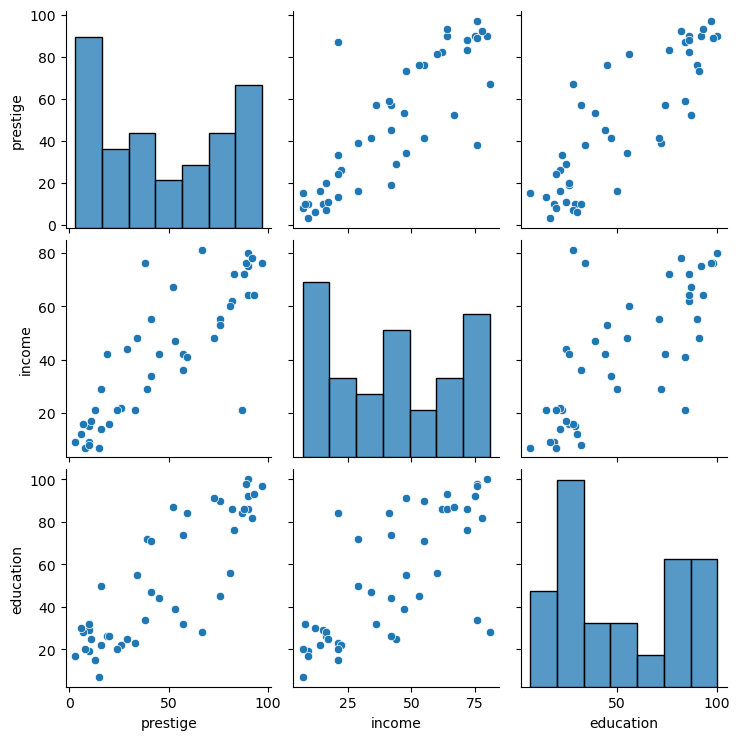

In [26]:
## Pairplot to check
sns.pairplot(duncan[['prestige', 'income', 'education']])
plt.show()

### Multicollinearity

- One measure of multicollinearity is the *Variance Inflation Factor*.
    + How much the multicollinearity is messing up with the estimates.
    
- To compute, it is fairly easy. As a rule-of-thumb, we would like to see values lower than 5.

- It is rarely a problem, though... Especially with large datasets.

In [27]:
## VIF
variables = duncan[['income', 'education']]
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[7.681386643382841, 7.681386643382841]

## Deciding on important variables

- Several criteria can be used. We will discuss later their trade-offs.

- But we have a couple of automated ways to select them that are easier to implement:

1. **Forward selection**:
    + Start with the null model and fit $p$ regressions for each predictor. 
    + Add to the model the variable that results in the lowest RSS.
    + Repeat until some stopping rule is satisfied.


#### Deciding on important variables

2. **Backward selection**:
    + Start with the full model, with all $p$ predictors. 
    + Remove the variable with the lowest p-value.
    + Fit the new model with p-1 variables.
    + Repeat until some stopping rule is satisfied.

#### Deciding on important variables

3. **Mixed selection**:
    + Start with the null model and fit $p$ regressions for each predictor.
    + Add to the model the variable that results in the lowest RSS.
    + Look at the p-value and remove it if it drops under a certain threshold.
    + Repeat until some stopping rule is satisfied.


## Application

- So far:
    + Is there a relationship between `prestige` and `income`? **Yes**
    + How strong is the relationship between `prestige` and `income`? **Yes**
    + Which variables are associated with `prestige`? **income, education, others?**
    + How can we accurately predict the prestige of professions not studied in this survey? **Yes**
    + Is the relationship linear? **It seems so**
    + Is there a synergy among predictors? **Good question: for PS2!**
    
- PS2 we are going to expand the study here to the other covariate, the `type` of the job. 
    + Note that it is a qualitative covariate!

# Classification

## Classification

- Linear regression is great! But it assumes we want to predict a continuous target variable.

- But there are situations when our response variables is qualitative.

**Examples:**

- Whether a country default its debt obligations?

- Whether a person voted Republican, Democrat, Independent, voted for a different party, or did not turnout to vote?

- What determines the number of FOI requests that a given public office receives every day?

- Is a country expected to meet, exceed, or not meet the Paris Treaty Nationally Determined Contributions?

All these questions are qualitative in nature.

## Class Example

- In 1988, the Chilean Dictator Augusto Pinochet conducted a referendum to whether he should step out.

- The FLACSO in Chile conducted a surver on 2700 respondents.

- We are going to build a model to predict their voting intentions.

## Data

| **Variable** | **Meaning** |
|:---:|---|
| region | A factor with levels:<br>- `C`, Central; <br>- `M`, Metropolitan Santiago area; <br>- `N`, North; <br>- `S`, South; <br>- `SA`, city of Santiago. |
| population | The population size of respondent's community. |
| sex | A factor with levels: <br>- `F`, female; <br>- `M`, male. |
| age | The respondent's age in years. |
| education | A factor with levels: <br>- `P`, Primary; <br>- `S`, Secondary; <br>- `PS`, Post-secondary. |
| income | The respondent's monthly income, in Pesos. |
| statusquo | A scale of support for the status-quo. |
| vote | A factor with levels: <br>- `A`, will abstain; <br>- `N`, will vote no (against Pinochet);<br>- `U`, is undecided; <br>- `Y`, will vote yes (for Pinochet). |

In [ ]:
## Loading the data
chile = pd.read_csv('')
chile.head()
chile = chile.dropna()
chile.shape()

## Why not run a Linear Regression?

You could ask this very valid question. And my answer here differs a bit from the book.

**My suggestion:**

- If you want to **measure a treatment effect**, or any other fitting where **explanation trumps prediction**, go with the linear regression.
    + Easy to explain to a lay audience.
    + Good polynomial expansion around the ATE.
    + Needs a careful design (in Causal Inference, the design is more important than the statistical method!).
    + Interaction terms are just partial derivatives of the fitted equation.

## Why not run a Linear Regression?

You could ask this very valid question. And my answer here differs a bit from the book.

**My suggestion:**

- If you want to **predict outcomes**, go with a classification model appropriate for your target variable unit.
    + You are not going to do `weird` prediction.
    + You have a marginal efficiency gain (in terms of Standard Errors).
    + If you have an ordered target variable, your model does look like more meaningful.
    + Need to be careful about interaction terms (has to do with taking derivatives of link function in Generalized Linear Models).

## Why not run a Linear Regression?

You could ask this very valid question. And my answer here differs a bit from the book.

**My suggestion:**

- Be **careful when you have discrete nominal variation in your target variable**:
    + Binary outcome: Linear Regression and Linear Discriminant Analysis are the same.
    + Three or more categories, like the `vote` in the Chilean dataset messes up badly with things.

## Book's Example

Chance of Default on Credit Card Debt by Account Balance:

![linear x logistic regression IRLR book](../img/linvslogit.png)

## Logistic Regression

- Logistic Regression belongs to a class of models called [Generalized Linear Models](https://en.wikipedia.org/wiki/Generalized_linear_model) (or GLM for short).

- A GLM, in a nutshell (and in a proudly lazy definition) is an expansion of Linear Model that assumes:
    + A Linear Relationship in part of the model
    + But then applies a non-linear transformation to the response variable.

- The non-linear transformation is called `link function`. Many link functions around (check [here](https://en.wikipedia.org/wiki/Generalized_linear_model) for various link functions).

- The link function is going to determine which types of models we run.

- When the outcome variable is binary, we may use the `Logistic` or `Probit` links.

## Logistic Regression

In a regression, we are investigating something along the lines of:

$$ \mathbb{E}[Y | X] \ = \ \beta_0 + \beta_1 X $$

But when the outcome is binary we would like to get:

$$ \mathbb{E}[Y | X] \ = \ \mathbb{P}(Y = 1 | X) $$

And the Logistic link is nothing but:

$$ \mathbb{P}(Y = 1 | X) \ = \ \dfrac{e^{(\beta_0 + \beta_1X)}}{1 + e^{(\beta_0 + \beta_1X)}} $$

## Logistic Regression

With a bit of manipulation, we get to something called odds ratio:

$$ \dfrac{\mathbb{P}(Y = 1 | X)}{\mathbb{P}(Y = 0 | X)} \ = \ \dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)} \ = \ e^{(\beta_0 + \beta_1X)} $$

And logging the thing gets rid of the Euler constant:

$$ \log \left( \dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)}\right) \ = \ \beta_0 + \beta_1X $$

And this is the Logit Link.

## Logistic Regression

Little detour to talk about odd ratios:

- Note the odd ratio: $\dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)}$

- It is a ratio between the chance of $Y = 1$ divided by the chance of $Y = 0$.

- Since probabilities are between zero and one, the ratio is always between $(0, \infty)$.

Example:

- If based on characteristics, two in every ten people vote for Pinochet, $\mathbb{P}(Y = 1 | X = \text{some characs.}) = 0.2$ and the odds ratio is $1/4$.

- If based on other set of characteristics, nine out of ten people vote for Pinochet, $\mathbb{P}(Y = 1 | X = \text{some other characs.}) = 0.9$ and the odds ratio is $9$.

- One is like the number that does not change the ratios.


## Logistic Regression

Little other detour to talk about the coefficients:

- In linear regression, changes in one unit of $x_i$ changes your target variable in $\beta_i$ units, on average.

- In logistic regression, changes in one unit of $x_i$ changes **the log odds** your target variable in $\beta_i$ units, on average.

- Multiplies the odds by $e^{\beta_i}$! This is **not** a straight line!

- Easy proxy (does not work for interaction terms): 
    + When $\beta_1$ is **positive**, it **increases** the $\mathbb{P}(Y = 1 | X)$
    + When $\beta_1$ is **negative**, it **decreases** the $\mathbb{P}(Y = 1 | X)$
    
- Try to compute the partial derivatives on $X$ and you will see the complications!

## Logistic Regression

Technical:

1. The estimation is through [maximizing the likelihood function](https://en.wikipedia.org/wiki/Likelihood_function).
    + This is outside the scope of the course, but an interesting topic to learn in an advanced course.


2. The hypothesis test for the coefficient's significance in here is a Z-test (based on the Normal distribution).
    + Null Hypothesis: $H_0: \ \beta_i = 0$ or alternatively $H_0: \ e^{\beta_i} = 1$.


3. Making predictions:
    + Just insert the predicted $\hat{\beta}$s on the equation.
    
$$ \hat{p}(X) \ = \ \dfrac{e^{\hat{\beta}_0 + \hat{\beta}_1 X}}{1 + e^{\hat{\beta}_0 + \hat{\beta}_1 X}} $$

## Logistic Regression

- Let's fit a Logistic Regression:

In [ ]:
# Initialize

modellogit = LogisticRegression().fit()


# Questions?

# See you next class
